## Analiza realcji między zdarzeniami - wykreślanie trapezów bazujących na średniej i odchyleniu standardowym zdarzeń

### import bibliotek

In [1]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from matplotlib.patches import Rectangle
from copy import deepcopy

from pm4py import discover_bpmn_inductive
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

### funkcje

In [2]:
def convert_logs_to_start_complete_by_status(df:pd.DataFrame, status: 'str', timestamp: 'str'):
    df['start_timestamp'] = df.loc[df[status] == 'start', timestamp]
    df['complete_timestamp'] = df.loc[df[status] == 'complete', timestamp]
    df.drop([status, timestamp], axis=1, inplace=True)
    return df

def grouped_start_complete_timestamp_to_one_row(df: pd.DataFrame):
    # wybór kolumn do grupowania
    columns_grouped = [col for col in df.columns.values if (col != 'start_timestamp' and col != 'complete_timestamp')]
    # grupowanie kolumn z wyjątkiem start oraz complete timestamp
    grouped = df.groupby(columns_grouped, as_index=False)

    # Agregowanie wartości start_timestamp i complete_timestamp za pomocą funkcji first i last
    return grouped.agg({'start_timestamp': 'first', 'complete_timestamp': 'last'})

def plot_only_lines(df: pd.DataFrame, xlim, ax, plot_color: str = 'r'):
    for i in range(df.shape[0] - 1):
        ax.plot([np.array(df['start_timestamp'])[i], np.array(df['complete_timestamp'])[i]], [np.array(df['case:concept:name'])[i],np.array(df['case:concept:name'])[i]], color=plot_color, alpha=0.5)
    ax.get_yaxis().set_visible(False)
    ax.set(xlim=xlim)
    
def plot1(df: pd.DataFrame, task_col:str, task1: str, task2: str, xlim):
    fig, ax = plt.subplots(figsize=[14,6])
    plot_only_lines(df.loc[df[task_col] == task1], xlim=xlim, ax=ax, plot_color='m')
    plot_only_lines(df.loc[df[task_col] == task2], xlim=xlim, ax=ax, plot_color='y')
    plt.show()
    
def selected_columns_to_compare(df:pd.DataFrame, instance_col: str, task_col: str, instance: str, task1: str, task2: str):
    return df.loc[(df[task_col] == task1) | (df[task_col] == task2) & (df[instance_col] == instance)]

def moved_to_side(df:pd.DataFrame, task_col: str, trace_col: str, task1: str, task2: str, side: str):
    left_side = np.min(df.start_timestamp)
    right_side = np.min(df.complete_timestamp)
    
    for i in df[trace_col].unique():
        case1 = ((df[trace_col] == i) & (df[task_col] == task1))
        case2 = ((df[trace_col] == i) & (df[task_col] == task2))
        
        if side == 'left':
            diff = pd.to_datetime(df[case1].start_timestamp) - left_side
            
            df.loc[case1, 'start_timestamp'] = df.loc[case1, 'start_timestamp'] - diff.item()
            df.loc[case2, 'start_timestamp'] = df.loc[case2, 'start_timestamp'] - diff.item()
            df.loc[case1, 'complete_timestamp'] = df.loc[case1, 'complete_timestamp'] - diff.item()
            df.loc[case2, 'complete_timestamp'] = df.loc[case2, 'complete_timestamp'] - diff.item()
       
        elif side == 'right':
            diff = right_side - pd.to_datetime(df[case2].complete_timestamp) 
            
            df.loc[case1, 'start_timestamp'] = df.loc[case1, 'start_timestamp'] + diff.item()
            df.loc[case2, 'start_timestamp'] = df.loc[case2, 'start_timestamp'] + diff.item()
            df.loc[case1, 'complete_timestamp'] = df.loc[case1, 'complete_timestamp'] + diff.item()
            df.loc[case2, 'complete_timestamp'] = df.loc[case2, 'complete_timestamp'] + diff.item()
        else:
            break
    return df

def calculate_timestamp_metrics(df: pd.DataFrame, task_col: str):
    number_of_traces = df.groupby([task_col]).count()
    n_task1 = number_of_traces.iloc[0,0]
    n_task2 = number_of_traces.iloc[1,0]

    mean_start1 = np.mean(df[df[task_col] == task1].start_timestamp)
    mean_start2 = np.mean(df[df[task_col] == task2].start_timestamp)

    mean_complete1 = np.mean(df[df[task_col] == task1].complete_timestamp)
    mean_complete2 = np.mean(df[df[task_col] == task2].complete_timestamp)

    std_start1 = np.std(df[df[task_col] == task1].start_timestamp)
    std_start2 = np.std(df[df[task_col] == task2].start_timestamp)

    std_complete1 = np.std(df[df[task_col] == task1].complete_timestamp)
    std_complete2 = np.std(df[df[task_col] == task2].complete_timestamp)
    
#     print(mean_start1,"+-", std_start1)
#     print(mean_complete1, '+-', std_complete1, end='\n\n')

#     print(mean_start2, '+-', std_start2)
#     print(mean_complete2,'+-', std_complete2)
    
    _, ax = plt.subplots(figsize=[14,8])
    ax.plot([mean_start1, mean_complete1, mean_complete1 + std_complete1, mean_start1-std_start1, mean_start1], [n_task1, n_task1, 0, 0, n_task1], 'm', linewidth=4)
    ax.plot([mean_start2, mean_complete2, mean_complete2 + std_complete2, mean_start2-std_start2, mean_start2], [n_task2, n_task2, 0, 0, n_task2], 'y', linewidth=4)
    ax.set(xlim=(xlim_lower, xlim_upper), ylim=(0, 1.1*np.max([n_task1,n_task2])))
    ax.get_yaxis().set_visible(False)

    plt.show()

### Załadowanie pliku formatu .xes

In [3]:
log = xes_importer.apply('logs/exercise6.xes')

C:\Users\sroka\AppData\Roaming\Python\Python39\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/132 [00:00<?, ?it/s]

### Przetworzenie logów do pd.Dataframe

In [4]:
df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

### Podgląd logow znajdujących się w załadowanym pliku

In [5]:
df.head()

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,Call Centre Agent,2005-12-31 23:00:00+00:00,check if sufficient information is available,start,0
1,Call Centre Agent,2006-01-13 23:00:00+00:00,check if sufficient information is available,complete,0
2,Call Centre Agent,2006-01-13 23:00:00+00:00,register claim,start,0
3,Call Centre Agent,2008-01-29 23:00:00+00:00,register claim,complete,0
4,Claims handler,2008-01-29 23:00:00+00:00,determine likelihood of claim,start,0


In [6]:
print(df.groupby(['lifecycle:transition'])['lifecycle:transition'].count())

lifecycle:transition
complete    821
start       821
Name: lifecycle:transition, dtype: int64


### Zamiana logów na format zawierający star_timestamp oraz complete_timestamp

In [7]:
df = convert_logs_to_start_complete_by_status(df, 'lifecycle:transition', 'time:timestamp')
df = grouped_start_complete_timestamp_to_one_row(df)
df.head()

,org:resource,concept:name,case:concept:name,start_timestamp,complete_timestamp
0,Call Centre Agent,check if sufficient information is available,0,2005-12-31 23:00:00+00:00,2006-01-13 23:00:00+00:00
1,Call Centre Agent,check if sufficient information is available,1,2005-12-31 23:00:00+00:00,2006-03-07 23:00:00+00:00
2,Call Centre Agent,check if sufficient information is available,10,2006-03-30 23:00:00+00:00,2006-04-09 23:00:00+00:00
3,Call Centre Agent,check if sufficient information is available,100,2008-07-26 23:00:00+00:00,2008-09-16 23:00:00+00:00
4,Call Centre Agent,check if sufficient information is available,101,2007-11-13 23:00:00+00:00,2008-01-19 23:00:00+00:00


In [8]:
df['org:resource'].unique()

array(['Call Centre Agent', 'Claims handler'], dtype=object)

# Analiza położenia zadań:

### Analiza 'org:resource' == 'Call Centre Agent'

In [9]:
call_centre_agent = df.loc[df['org:resource'] == 'Call Centre Agent']
tasks = call_centre_agent['concept:name'].unique()
print(tasks)

['check if sufficient information is available' 'end' 'register claim']


In [10]:
check_if_sufficient = call_centre_agent.loc[call_centre_agent['concept:name'] == 'check if sufficient information is available']
register_claim = call_centre_agent.loc[call_centre_agent['concept:name'] == 'register claim']
end = call_centre_agent.loc[call_centre_agent['concept:name'] == 'end']

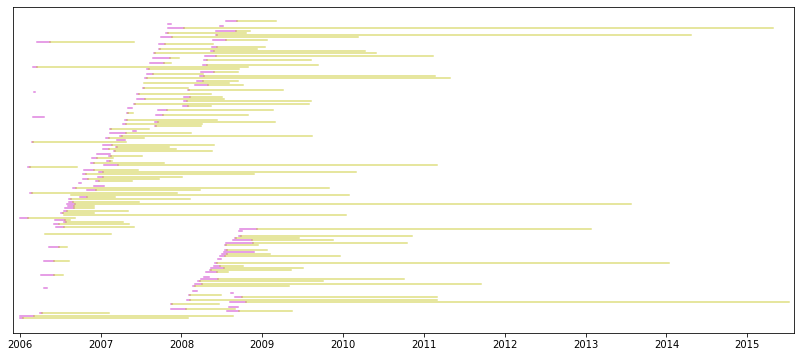

In [11]:
xlim_lower = datetime.strptime('2005-12-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2015-08-01', '%Y-%m-%d')

fig, ax = plt.subplots(figsize=[14,6])
plot_only_lines(check_if_sufficient, xlim=(xlim_lower, xlim_upper), plot_color='m', ax=ax)
plot_only_lines(register_claim, xlim=(xlim_lower, xlim_upper), plot_color='y', ax=ax)

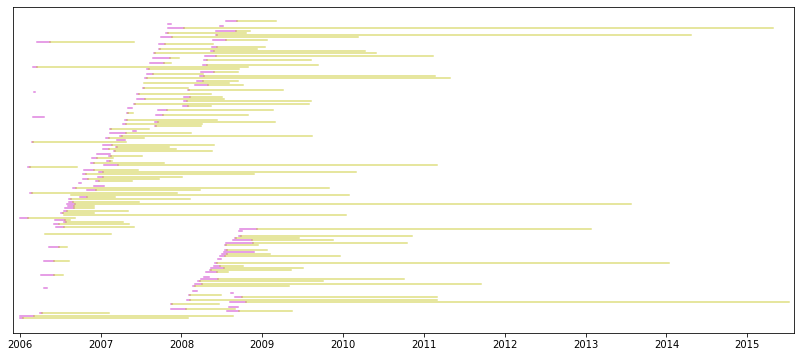

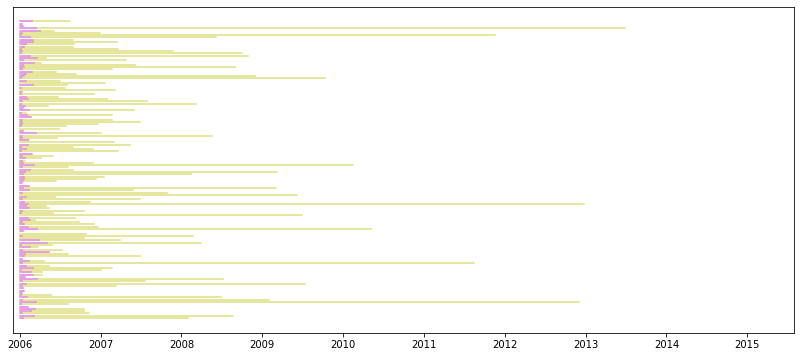

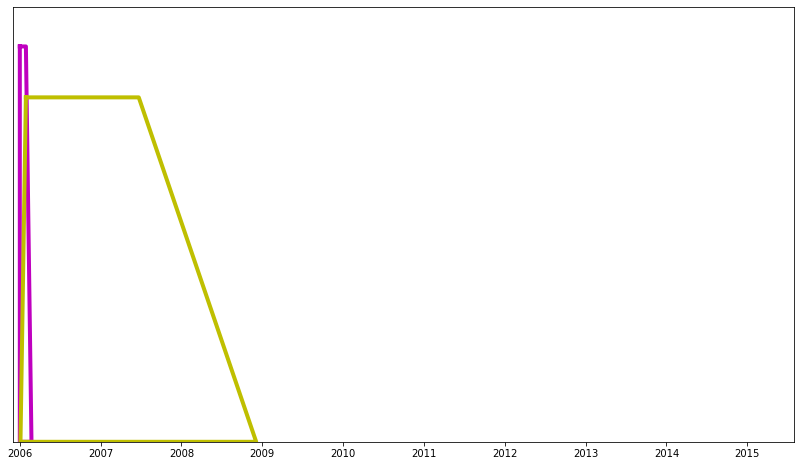

In [12]:
# wybór parametrów
xlim_lower = datetime.strptime('2005-12-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2015-08-01', '%Y-%m-%d')

instance = 'Call Centre Agent'
task_col = 'concept:name'
task1 = 'check if sufficient information is available'
task2 = 'register claim'

selected_df = selected_columns_to_compare(df, instance_col='org:resource', task_col='concept:name', instance=instance, task1=task1, task2=task2)
plot1(selected_df, task_col=task_col, task1=task1, task2=task2, xlim=(xlim_lower, xlim_upper))

df1 = moved_to_side(selected_df, task_col=task_col, trace_col='case:concept:name',task1=task1, task2=task2, side='left') 
plot1(df1, task_col=task_col, task1=task1, task2=task2, xlim=(xlim_lower, xlim_upper))

calculate_timestamp_metrics(df1, task_col)

### Analiza 'org:resource' == 'Claims handler'

In [13]:
claims_handler = df.loc[df['org:resource'] == 'Claims handler']
print(df['concept:name'].unique())

['check if sufficient information is available' 'end' 'register claim'
 'advise claimant on reimbursement' 'assess claim' 'close claim'
 'determine likelihood of claim' 'initiate payment']


In [14]:
assess_claim = claims_handler.loc[claims_handler['concept:name'] == 'assess claim']
close_claim = claims_handler.loc[claims_handler['concept:name'] == 'close claim']
determine_likelihood_of_claim = claims_handler.loc[claims_handler['concept:name'] == 'determine likelihood of claim']
advise_claimant_on_reimbursement = claims_handler.loc[claims_handler['concept:name'] == 'advise claimant on reimbursement']
end = claims_handler.loc[claims_handler['concept:name'] == 'end']

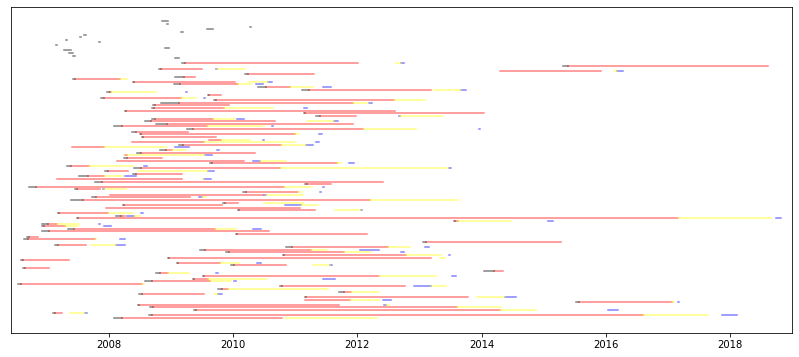

In [15]:
xlim_lower = datetime.strptime('2006-06-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2019-01-01', '%Y-%m-%d')

fig, ax = plt.subplots(figsize=[14,6])
plot_only_lines(assess_claim, xlim=(xlim_lower, xlim_upper), plot_color='red', ax=ax)
plot_only_lines(close_claim, xlim=(xlim_lower, xlim_upper), plot_color='blue', ax=ax)
plot_only_lines(determine_likelihood_of_claim, xlim=(xlim_lower, xlim_upper), plot_color='black', ax=ax)
plot_only_lines(advise_claimant_on_reimbursement, xlim=(xlim_lower, xlim_upper), plot_color='yellow', ax=ax)

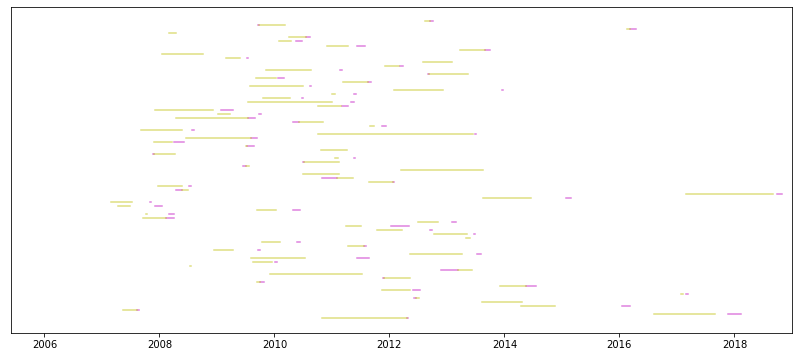

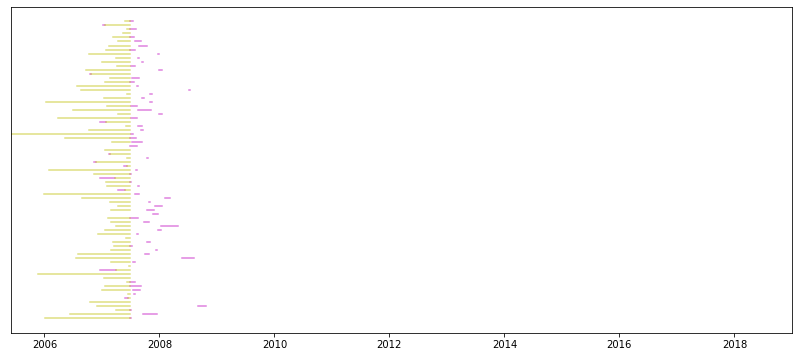

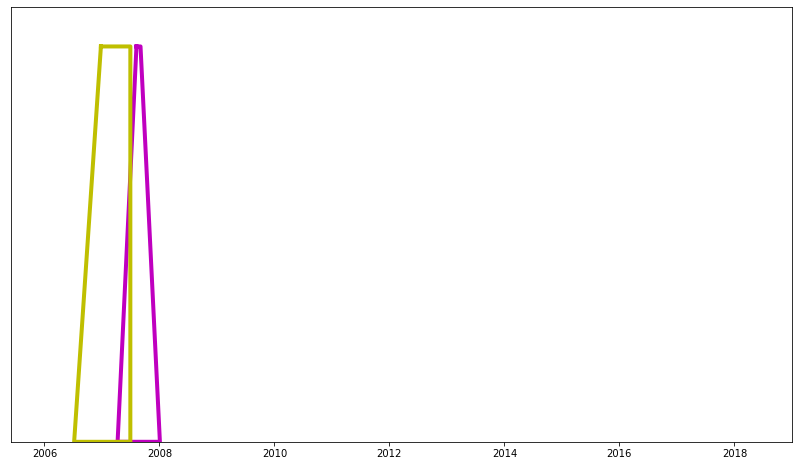

In [21]:
xlim_lower = datetime.strptime('2005-06-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2019-01-01', '%Y-%m-%d')

instance = 'Claims handler'
task_col = 'concept:name'
task1 = 'close claim'
task2 = 'advise claimant on reimbursement'

selected_df = selected_columns_to_compare(df, instance_col='org:resource', task_col='concept:name', instance=instance, task1=task1, task2=task2)
plot1(selected_df, task_col=task_col, task1=task1, task2=task2, xlim=(xlim_lower, xlim_upper))

df1 = moved_to_side(selected_df, task_col=task_col, trace_col='case:concept:name',task1=task1, task2=task2, side='right') 
plot1(df1, task_col=task_col, task1=task1, task2=task2, xlim=(xlim_lower, xlim_upper))

calculate_timestamp_metrics(df1, task_col)

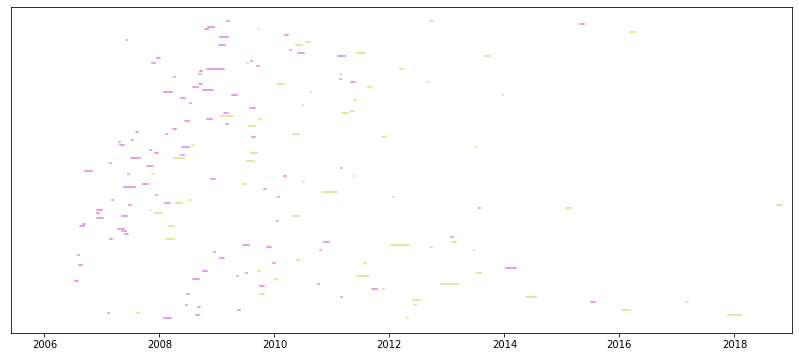

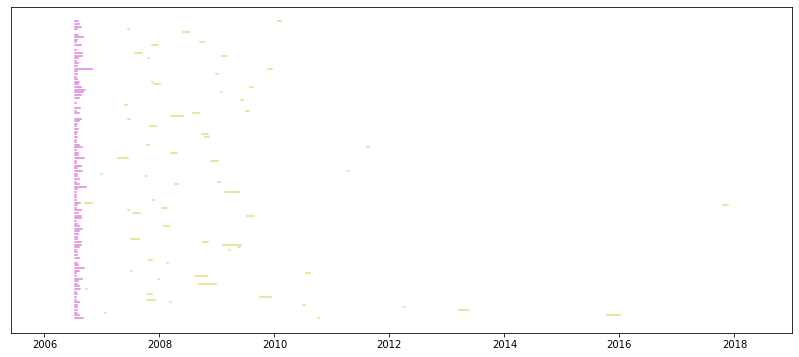

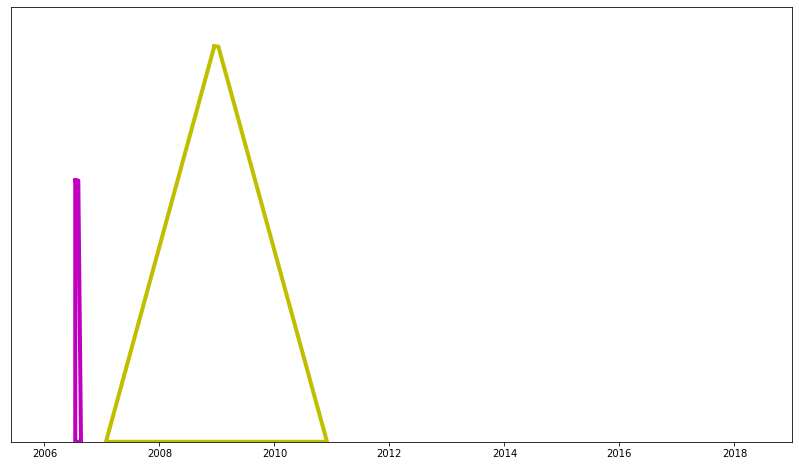

In [17]:
xlim_lower = datetime.strptime('2005-06-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2019-01-01', '%Y-%m-%d')

instance = 'Claims handler'
task_col = 'concept:name'

task1 = 'determine likelihood of claim'
task2 = 'close claim'

selected_df = selected_columns_to_compare(df, instance_col='org:resource', task_col='concept:name', instance=instance, task1=task1, task2=task2)
plot1(selected_df, task_col=task_col, task1=task1, task2=task2, xlim=(xlim_lower, xlim_upper))

df1 = moved_to_side(selected_df, task_col=task_col, trace_col='case:concept:name',task1=task1, task2=task2, side='left') 
plot1(df1, task_col=task_col, task1=task1, task2=task2, xlim=(xlim_lower, xlim_upper))

calculate_timestamp_metrics(df1, task_col)

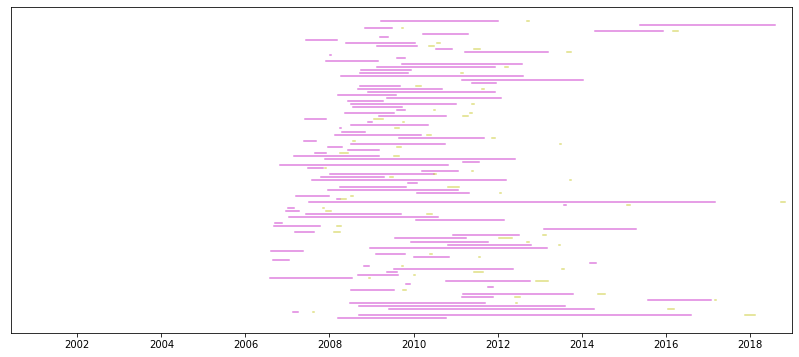

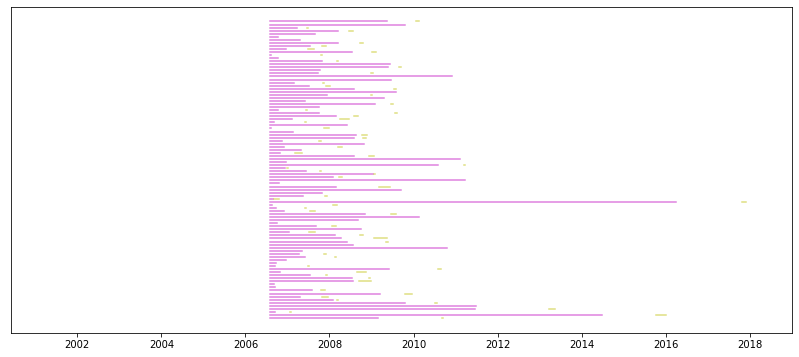

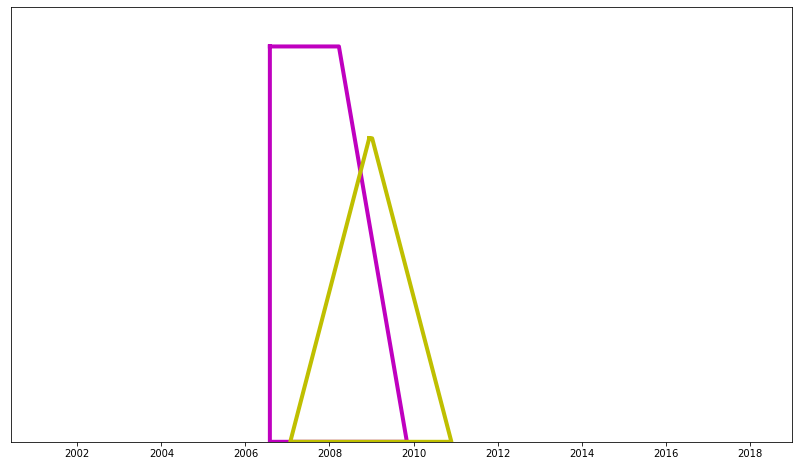

In [23]:
xlim_lower = datetime.strptime('2000-06-01', '%Y-%m-%d')
xlim_upper = datetime.strptime('2019-01-01', '%Y-%m-%d')

instance = 'Claims handler'
task_col = 'concept:name'

task1 = 'assess claim'
task2 = 'close claim'

selected_df = selected_columns_to_compare(df, instance_col='org:resource', task_col='concept:name', instance=instance, task1=task1, task2=task2)
plot1(selected_df, task_col=task_col, task1=task1, task2=task2, xlim=(xlim_lower, xlim_upper))

df1 = moved_to_side(selected_df, task_col=task_col, trace_col='case:concept:name',task1=task1, task2=task2, side='left') 
plot1(df1, task_col=task_col, task1=task1, task2=task2, xlim=(xlim_lower, xlim_upper))

calculate_timestamp_metrics(df1, task_col)